<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth_results.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Choropleth map generation for analysis of choropleth classes


This notebook is used to generate choropleth maps to analyze classes of enumeration units by both humans and computers 

The following cell makes sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [1]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from cgl.cgl.util.get_adjacency_matrix import *
from cgl.cgl.util.draw_polygons_shapex import *
from cgl.cgl.util.get_attribute_by_name import *
from cgl.cgl.util.evaluate_all import *
from cgl.cgl.util.pareto_ranking import *
from cgl.cgl.util.parallel_coordinates import *
from cgl.cgl.util.xcolorbrewer import *
from cgl.cgl.util.breakpoints2 import *

import time
import random
# random.seed(10)
import numpy as np
import pickle
import math

import urllib.request as request

import json

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import mapclassify

# Map Data

In this tutorial, we use the data of 1959 Illinois farm products. This data set has been used in many cartographic studies such as [this](https://www.tandfonline.com/doi/full/10.1111/1467-8306.9303005). The data is converted to a GeoJSON file and can be loaded directly from its [github source](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson).

In [3]:
# url_il_data = 'https://raw.githubusercontent.com/gisalgs/data/master/OH_geog.geojson'
# with request.urlopen(url_il_data) as response:
#     shp = json.loads(response.read())

baseMapPath = r'C:\Users\jiali\Desktop\choroColorRead\surveyMaking\baseMaps'
f = open(baseMapPath + '\\' + 'uscnty48area_102008.geojson')
shp = json.load(f)

all_features = shp['features']
print(len(all_features))
baseMap = 'us'

3109


In [4]:
all_features[0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [5]:
all_features[0]['properties'].keys()

dict_keys(['NAME', 'STATE_NAME', 'FIPS', 'UrbanPop', 'Area', 'AreaKM2', 'GEO_ID', 'PopDensity'])

We need to get the bounds of the coordinates for each enumeration unit:

In [6]:
envelopes = get_feature_envelopes(all_features) # list of [xmin, ymin, xmax, ymax]
# geom_bounds = [min([p[0] for p in envelopes]), min([p[1] for p in envelopes]), max([p[2] for p in envelopes]), max([p[3] for p in envelopes])]
geom_bounds = {
    'xmin': min([p[0] for p in envelopes]), 
    'ymin': min([p[1] for p in envelopes]), 
    'xmax': max([p[2] for p in envelopes]), 
    'ymax': max([p[3] for p in envelopes])
}

geom_bounds # [xmin, ymin, xmax, ymax]

{'xmin': -2235809.497613872,
 'ymin': -1643544.949341902,
 'xmax': 2125197.68616152,
 'ymax': 1322159.8643133966}

Let's quickly draw a map to make sure the geometries are loaded correctly.

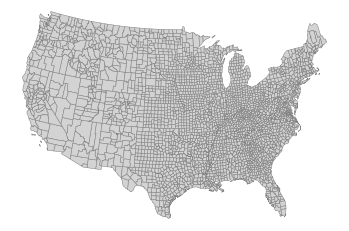

In [7]:
draw_shape(all_features)
plt.axis('off')
plt.axis('equal')
plt.show()

With the data loaded, we need to obtain the adjacency matrix (list), all the values of the attribute synthesized by us, and all the unique values (sorted). 

In [8]:
# adjacent list for the enumration units
adjacency_list = adjacency_matrix(all_features, output='L')
adjacency_list

[[3, 2],
 [5, 2],
 [5, 4],
 [6, 2],
 [6, 4],
 [6, 5],
 [7, 3],
 [8, 3],
 [9, 3],
 [9, 7],
 [10, 3],
 [10, 8],
 [10, 9],
 [11, 9],
 [11, 10],
 [12, 11],
 [13, 12],
 [14, 12],
 [14, 13],
 [15, 14],
 [16, 14],
 [16, 15],
 [17, 16],
 [21, 4],
 [21, 5],
 [23, 22],
 [25, 19],
 [25, 23],
 [25, 24],
 [26, 19],
 [26, 23],
 [26, 25],
 [27, 26],
 [28, 20],
 [28, 27],
 [29, 21],
 [30, 20],
 [30, 21],
 [30, 28],
 [30, 29],
 [31, 21],
 [31, 29],
 [31, 30],
 [32, 4],
 [32, 21],
 [32, 31],
 [34, 33],
 [35, 33],
 [36, 34],
 [38, 37],
 [40, 39],
 [41, 40],
 [42, 36],
 [42, 37],
 [43, 42],
 [44, 43],
 [45, 19],
 [45, 20],
 [45, 26],
 [45, 27],
 [45, 28],
 [46, 44],
 [47, 0],
 [50, 31],
 [50, 32],
 [50, 48],
 [51, 35],
 [53, 43],
 [53, 44],
 [53, 52],
 [54, 45],
 [54, 51],
 [55, 51],
 [55, 52],
 [57, 56],
 [58, 56],
 [59, 30],
 [59, 31],
 [59, 50],
 [60, 51],
 [60, 54],
 [60, 55],
 [60, 56],
 [60, 57],
 [61, 20],
 [61, 45],
 [61, 54],
 [61, 59],
 [62, 20],
 [62, 30],
 [62, 59],
 [62, 61],
 [63, 48],
 [63,

Specify the parameters to synthesize maps besides base map, including color scheme, number of classes

In [405]:
numclass = 8  # 4, 6, 8
# colorScheme = 'Blues'
colorScheme = 'RdBu'
if numclass == 4:
    numDig = 3
else:
    numDig = 3

#### 1. Generate spatial data (all values) with negative spatial autocorrelation for the enumeration units

##### (1) Use checker board with full negative spatial autocorrelation to overlap with the base map (doesn't work to synthesize data with significant negative spatial autocorrelation)

##### (2) Use BFS to synthesize data for units and adjacent units to make sure they are not in the same class  

Load data with negative spatial autocorrelation

In [406]:
dataGenerationPath = r'C:\Users\jiali\Desktop\choroColorRead\surveyMaking\code'

In [407]:
pattern = 'neg'
with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_' + pattern + '.pickle', 'rb') as f:
    all_values_neg = pickle.load(f)

In [408]:
unique_values = list(set(all_values_neg))
m = len(all_values_neg)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 0.0002752831982338333 0.9999803671724634


##### Defining a classification

A Python class called `Intervals` is defined in the [classify.py](https://github.com/compgeog/cgl/blob/master/cgl/util/classify.py) that will be cloned here (see the beginning of this tutorial). There are multiple ways to create a classification. Below is an example using a set of lower and upper bounds:

In [409]:
quantiles = mapclassify.Quantiles(all_values_neg,k=numclass)
quantiles

Quantiles           

  Interval     Count
--------------------
[0.00, 0.13] |   389
(0.13, 0.26] |   389
(0.26, 0.38] |   388
(0.38, 0.50] |   389
(0.50, 0.63] |   388
(0.63, 0.75] |   389
(0.75, 0.87] |   388
(0.87, 1.00] |   389

In [410]:
upperBounds = quantiles.bins.tolist()
intervals_bounds = []
for i in range(len(upperBounds)):
    if i == 0:
        bound = [0, upperBounds[i]]
    else:
        bound = [upperBounds[i - 1], upperBounds[i]]
    intervals_bounds.append(bound)
intervals = Intervals()
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.12511538874784592], [0.12511538874784592 - 0.2551308874858734], [0.2551308874858734 - 0.3758267679507158], [0.3758267679507158 - 0.5035253927575859], [0.5035253927575859 - 0.6291154706337551], [0.6291154706337551 - 0.7472567457931584], [0.7472567457931584 - 0.8734279068729087], [0.8734279068729087 - 0.9999803671724634]

We can draw a choropleth map using the classification scheme created from the above section. 

We first need to calculate the geometry bounds of the map, which will be used later.

In [411]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

We draw the map using the intervals stored in `intervals`:

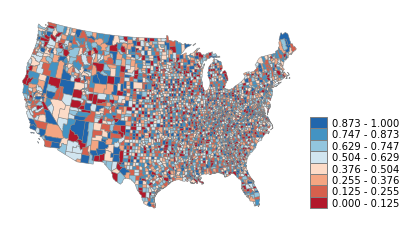

In [412]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_neg]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/16  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=numDig)

plt.axis('off')
plt.axis('equal')
# plt.show()

imageName = baseMap +'_' + colorScheme + '_' + str(numclass) + '_' + pattern + '.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')

Check gobal Moran's I for the data with the base map

In [413]:
classes = [intervals.get_class(v) for v in all_values_neg]

In [414]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_neg[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_neg, adjacency_list)

-0.20354186029511073

#### 2. Generate spatial data (all values) with NO spatial autocorrelation for the enumeration units

In [415]:
# randomly select values for nonpattern maps
# all_values_nonAuto = [random.uniform(0, 1) for i in range(len(all_features))] 
pattern = 'nonAuto'
with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_' + pattern + '.pickle', 'rb') as f:
    all_values_nonAuto = pickle.load(f)

In [416]:
unique_values = list(set(all_values_nonAuto))
m = len(all_values_nonAuto)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 0.00014093831546813096 0.9994915227467354


In [417]:
quantiles = mapclassify.Quantiles(all_values_nonAuto,k=numclass)
quantiles

Quantiles           

  Interval     Count
--------------------
[0.00, 0.13] |   389
(0.13, 0.27] |   389
(0.27, 0.38] |   388
(0.38, 0.49] |   389
(0.49, 0.62] |   388
(0.62, 0.74] |   389
(0.74, 0.88] |   388
(0.88, 1.00] |   389

In [418]:
upperBounds = quantiles.bins.tolist()
intervals_bounds = []
for i in range(len(upperBounds)):
    if i == 0:
        bound = [0, upperBounds[i]]
    else:
        bound = [upperBounds[i - 1], upperBounds[i]]
    intervals_bounds.append(bound)
intervals = Intervals()
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.1314347469329506], [0.1314347469329506 - 0.2662815027232086], [0.2662815027232086 - 0.37713518328263107], [0.37713518328263107 - 0.4927479878159511], [0.4927479878159511 - 0.6213886561958625], [0.6213886561958625 - 0.7433968187309842], [0.7433968187309842 - 0.875089883094107], [0.875089883094107 - 0.9994915227467354]

In [419]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

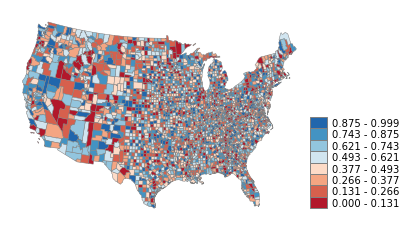

In [420]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_nonAuto]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/16  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=numDig)
plt.axis('off')
plt.axis('equal')
# plt.show()

imageName = baseMap + '_' + colorScheme + '_' + str(numclass) + '_' + pattern + '.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')

In [421]:
classes = [intervals.get_class(v) for v in all_values_nonAuto]

In [422]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_nonAuto[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ all_values_nonAuto for i in classes ]
moransi2(all_values_nonAuto, adjacency_list)

0.010656919939681243

#### 3. Generate spatial data (all values) with POSITIVE spatial autocorrelation for the enumeration units

We use midpoint displacement interpolation to generate a grid with some trend to synthesize data with positive spatial autocorrelation.

The next a couple of cells are the functions needed for this section

##### (1) large positive spatial autocorrelation

In [423]:
# get value from generated data with MidPoint2.py
# all_values_pos_large = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values
pattern = 'pos_large'
with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_' + pattern + '.pickle', 'rb') as f:
    all_values_pos_large = pickle.load(f)

In [424]:
unique_values = list(set(all_values_pos_large))
m = len(all_values_pos_large)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3093 3109 0.155092830322963 0.9943117197295516


In [425]:
quantiles = mapclassify.Quantiles(all_values_pos_large,k=numclass)
quantiles

Quantiles           

  Interval     Count
--------------------
[0.16, 0.44] |   389
(0.44, 0.50] |   389
(0.50, 0.54] |   388
(0.54, 0.56] |   389
(0.56, 0.59] |   388
(0.59, 0.63] |   389
(0.63, 0.69] |   388
(0.69, 0.99] |   389

In [426]:
upperBounds = quantiles.bins.tolist()
intervals_bounds = []
for i in range(len(upperBounds)):
    if i == 0:
        bound = [0, upperBounds[i]]
    else:
        bound = [upperBounds[i - 1], upperBounds[i]]
    intervals_bounds.append(bound)
intervals = Intervals()
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.4377284744652101], [0.4377284744652101 - 0.5016222732215928], [0.5016222732215928 - 0.5363287335353965], [0.5363287335353965 - 0.5644832535476644], [0.5644832535476644 - 0.5930134116272283], [0.5930134116272283 - 0.6286382126004773], [0.6286382126004773 - 0.6865758578726218], [0.6865758578726218 - 0.9943117197295516]

In [427]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

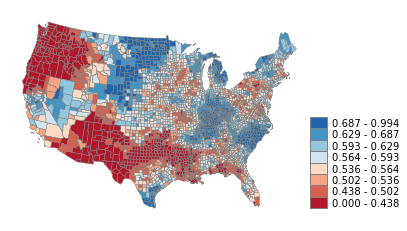

In [428]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_large]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/16  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=numDig)

plt.axis('off')
plt.axis('equal')
# plt.show()

imageName = baseMap + '_' + colorScheme + '_' + str(numclass) + '_' + pattern + '.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')

In [429]:
classes = [intervals.get_class(v) for v in all_values_pos_large]

In [430]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values_pos_large[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_large, adjacency_list)

0.8610989317394032

##### (2) small positive spatial autocorrelation

In [431]:
pattern = 'pos_small'
with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_' + pattern + '.pickle', 'rb') as f:
    all_values_pos_small = pickle.load(f)

In [432]:
quantiles = mapclassify.Quantiles(all_values_pos_small,k=numclass)
quantiles

Quantiles           

  Interval     Count
--------------------
[0.23, 0.43] |   389
(0.43, 0.47] |   389
(0.47, 0.50] |   388
(0.50, 0.53] |   389
(0.53, 0.56] |   388
(0.56, 0.59] |   389
(0.59, 0.63] |   388
(0.63, 0.85] |   389

In [433]:
upperBounds = quantiles.bins.tolist()
intervals_bounds = []
for i in range(len(upperBounds)):
    if i == 0:
        bound = [0, upperBounds[i]]
    else:
        bound = [upperBounds[i - 1], upperBounds[i]]
    intervals_bounds.append(bound)
intervals = Intervals()
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.4266680749004099], [0.4266680749004099 - 0.4673615076649677], [0.4673615076649677 - 0.49892305335940973], [0.49892305335940973 - 0.5269498172918048], [0.5269498172918048 - 0.5553402736390536], [0.5553402736390536 - 0.5870012819769039], [0.5870012819769039 - 0.6307055002828613], [0.6307055002828613 - 0.851694407224588]

In [434]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

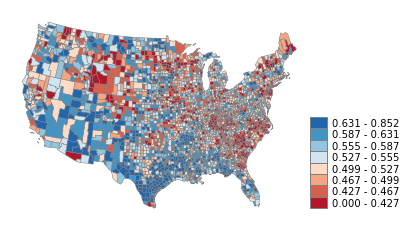

In [435]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_small]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/16  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=numDig)

plt.axis('off')
plt.axis('equal')
# plt.show()

imageName = baseMap + '_' + colorScheme + '_' + str(numclass) + '_' + pattern + '.jpg'
plt.savefig(imageName,dpi=300,bbox_inches='tight')

In [436]:
classes = [intervals.get_class(v) for v in all_values_pos_small]

In [437]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_small, adjacency_list)

0.45103197520594795